# Multimodal model: combining text and numerical features
### Author: Jan

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.6 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
     |████████████████████████████████| 101 kB 7.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 4.8 MB/s 
     |████████████████████████████████| 212 kB 53.8 MB/s 
     |████████████████████████████████| 1.1 MB 66.2 MB/s 
     |████████████████████████████████| 140 kB 72.4 MB/s 
     |████████████████████████████████| 127 kB 70.7 MB/s 
     |████████████████████████████████| 144 kB 69.3 MB/s 
     |████████████████████████████████| 271 kB 72.4 MB/s 
     |████████████

In [2]:
import transformers
import datasets
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# from datasets import load_dataset
model_cp = "distilbert-base-german-cased"

# train_path = "./data/train_ratings_with_features.csv"
# validation_path = "./data/validation_ratings_with_features.csv"
# test_path = "./data/test_ratings_with_features.csv"

# trying in colab
train_path = "/content/train_ratings_with_features.csv" #/content/test_ratings_with_features.csv
validation_path = "/content/validation_ratings_with_features.csv"
test_path = "/content/test_ratings_with_features.csv"


USE_DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(USE_DEVICE)

cuda:0


In [4]:
data = pd.read_csv(train_path)
# data.drop(["Unnamed: 0", "ID"],axis=1) # take away the non data columns?
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data.iloc[:,:], test_size=0.1, random_state=42) #trim dataset here!

feature_list = train_set.loc[:, [col for col in train_set.columns if col.startswith("F_ratio")]].columns #downselect features here: F_, F_ratio, F_ngram, F_get, F_in, F_count, F_text?
feature_list = ["F_ngram_c", "F_ngram_a"] # overwrite it with custom selection

def get_feature_tensor(row):
    return torch.tensor(row[1].loc[[col for col in row[1].axes[0] if col in feature_list]]) #dimension change for batch dim??  we fake the batch dim inside the model later on!

FEATURE_DIM = len(feature_list)
print(FEATURE_DIM)
print(feature_list)

2
['F_ngram_c', 'F_ngram_a']


In [5]:
#test cell
test_row = next(test_set.iterrows())
test_row[1].axes[0]
get_feature_tensor(test_row) #features
test_row[1]["Sentence"] #sentence
test_row[1]["MOS"] #target label

4.4

Colab/huggingface modifications:

In [6]:
from datasets import load_dataset, load_metric, dataset_dict
metric = load_metric("mse")
dataset = load_dataset("csv", data_files=train_path)
dataset = dataset["train"] #undo dict?
dataset = dataset.train_test_split(test_size=0.1, shuffle=True) # maybe do size=0.01 for submissions??
dataset

Using custom data configuration default-3e4e7a8eede6b210


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3e4e7a8eede6b210/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'Sentence', 'MOS', 'F_compound_ratio', 'F_compound_nouns_ratio', 'F_subjunctive', 'F_ratio_nom', 'F_ratio_gen', 'F_ratio_dat', 'F_ratio_acc', 'F_text_level', 'F_ppl_gerpt2', 'F_get_type_token_ratio', 'F_get_ratio_of_function_words', 'F_get_ratio_of_coordinating_clauses', 'F_get_ratio_of_subordinate_clauses', 'F_get_ratio_prepositional_phrases', 'F_get_ratio_relative_phrases', 'F_get_ratio_clauses', 'F_get_ratio_named_entities', 'F_get_ratio_mwes', 'F_get_parse_tree_height', 'F_check_if_head_is_noun', 'F_check_if_head_is_verb', 'F_check_if_one_child_of_root_is_subject', 'F_check_passive_voice', 'F_is_non_projective', 'F_get_average_length_NP', 'F_get_average_length_VP', 'F_get_avg_length_PP', 'F_get_ratio_of_nouns', 'F_get_ratio_of_verbs', 'F_get_ratio_of_adjectives', 'F_get_ratio_of_adpositions', 'F_get_ratio_of_adverbs', 'F_get_ratio_of_auxiliary_verbs', 'F_get_ratio_of_conjunctions', 'F_get_ratio_of_determiners', 'F_get_rati

In [7]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, AutoTokenizer
from transformers.modeling_outputs import SequenceClassifierOutput
tokenizer = AutoTokenizer.from_pretrained(model_cp)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468k [00:00<?, ?B/s]

In [8]:
def tokenizing_function(sentence):
    return tokenizer(sentence, truncation = True)

def preprocess_function(row):
    tokenized_sentence = tokenizing_function(row["Sentence"])
    # print(tokenized_sentence)
    feature_tensor = get_feature_tensor((0,pd.Series(row))) #whack into our previous format of (index,pd.Series)
    tokenized_sentence["numerical_tensor"] = feature_tensor.tolist()
    # print(type(feature_tensor))
    tokenized_sentence["labels"] = row["MOS"]
    return tokenized_sentence


In [9]:
prepared_dataset = dataset.map(preprocess_function, batched=False, load_from_cache_file=False) #batched=True doesn't want to work; load_from_cache_file=False to force it to reload...
prepared_dataset = prepared_dataset.remove_columns(dataset["train"].column_names)
prepared_dataset

Parameter 'function'=<function preprocess_function at 0x7f5b48eb3170> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/900 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'numerical_tensor', 'labels'],
        num_rows: 900
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'numerical_tensor', 'labels'],
        num_rows: 100
    })
})

defining the custom head for the model:


In [10]:
# cut from: https://github.com/georgian-io/Multimodal-Toolkit/blob/master/multimodal_transformers/model/tabular_transformers.py
# with eyes on: https://github.com/huggingface/transformers/blob/v4.20.1/src/transformers/models/distilbert/modeling_distilbert.py#L687
class DistilBertWithNumerical(DistilBertForSequenceClassification): 
    """
    DistilBert Model transformer with a sequence classification/regression head as well as
    a module to combine numerical features with the Distilbert output
    Parameters:
        hf_model_config (:class:`~transformers.DistilBertConfig`):
            Model configuration class with all the parameters of the model.
            This object must also have a tabular_config member variable that is a
            :obj:`TabularConfig` instance specifying the configs for :obj:`TabularFeatCombiner`
    """
    def __init__(self, hf_model_config, numerical_features=0, num_labels=1): #default entries
        hf_model_config.num_labels = num_labels
        super().__init__(hf_model_config)
        # tabular_config = hf_model_config.tabular_config
        # if type(tabular_config) is dict:  # when loading from saved model
        #     tabular_config = TabularConfig(**tabular_config)
        # else:
        #     self.config.tabular_config = tabular_config.__dict__
        
        self.text_feat_dim = hf_model_config.hidden_size
        self.hidden_dropout_prob = hf_model_config.seq_classif_dropout
        # self.tabular_combiner = TabularFeatCombiner(tabular_config)
        self.num_labels = hf_model_config.num_labels
        self.numerical_features_dim = numerical_features
        self.combined_dim = self.text_feat_dim + self.numerical_features_dim
        # if tabular_config.use_simple_classifier:
        #     self.tabular_classifier = nn.Linear(combined_feat_dim,
        #                                         tabular_config.num_labels)
        # else:
        #     dims = calc_mlp_dims(combined_feat_dim,
        #                          division=tabular_config.mlp_division,
        #                          output_dim=tabular_config.num_labels)
        #     self.tabular_classifier = MLP(combined_feat_dim,
        #                                   tabular_config.num_labels,
        #                                   num_hidden_lyr=len(dims),
        #                                   dropout_prob=tabular_config.mlp_dropout,
        #                                   hidden_channels=dims,
        #                                   bn=True)
        # self.pre_classifier_bert = nn.Linear(self.text_feat_dim, self.text_feat_dim) #inhereted as pre_classifier
        self.pre_classifier_feats = nn.Linear(self.numerical_features_dim, self.numerical_features_dim) #square on the features
        self.combined_layer = nn.Linear(self.combined_dim, self.combined_dim) #big square on the stacked sensors
        # self.classifier.in_features = self.combined_dim #adjust for out combination -> can't be done as weigths are initialized already
        self.classifier = nn.Linear(self.combined_dim, self.num_labels) #inherented as classifier so we overwrite it

    # @add_start_docstrings_to_callable(DISTILBERT_INPUTS_DOCSTRING.format("(batch_size, sequence_length)"))
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict= None,
        # class_weights=None,
        # cat_feats=None,
        numerical_tensor=None
    ):
        r"""
        class_weights (:obj:`torch.FloatTensor` of shape :obj:`(tabular_config.num_labels,)`,`optional`, defaults to :obj:`None`):
            Class weights to be used for cross entropy loss function for classification task
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
            If :obj:`tabular_config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`tabular_config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        # cat_feats (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, tabular_config.cat_feat_dim)`,`optional`, defaults to :obj:`None`):
        #     Categorical features to be passed in to the TabularFeatCombiner - no longer needed!
        numerical_feats (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, tabular_config.numerical_feat_dim)`,`optional`, defaults to :obj:`None`):
            Numerical features to be passed in to the TabularFeatCombiner
    Returns: # not yet implemented...
        :obj:`tuple` comprising various elements depending on configuration and inputs:
        # loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when :obj:`label` is provided):
        #     Classification (or regression if tabular_config.num_labels==1) loss.
        logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, tabular_config.num_labels)`):
            Classification (or regression if tabular_config.num_labels==1) scores (before SoftMax).
        # classifier_layer_outputs(:obj:`list` of :obj:`torch.FloatTensor`):
        #     The outputs of each layer of the final classification layers. The 0th index of this list is the
        #     combining module's output
        """

        distilbert_output = self.distilbert(
            input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        text_feats = nn.ReLU()(pooled_output)  # (bs, dim)
        # text_feats = self.dropout(pooled_output) # <- reduced bert outputs

        if numerical_tensor.dim() == 1: #in case of getting no batch dim for this input (legacy code)
            numerical_tensor = numerical_tensor.view(1,-1) #implies a batch of 1?
        numerical_output = self.pre_classifier_feats(numerical_tensor)
        numerical_output = nn.ReLU()(numerical_output) # changed the activation function here...
        # numerical_output = self.dropout(numerical_output) # <- reduced numerical features
        
        combined_output = torch.cat((text_feats, numerical_output), dim=1) #Copilot regelt?
        combined_output = self.combined_layer(combined_output)
        # print(combined_output.shape) #DEBUG
        combined_output = nn.ReLU()(combined_output)

        # loss, logits, classifier_layer_outputs = hf_loss_func(combined_output,
        #                                                       self.tabular_classifier,
        #                                                       labels,
        #                                                       self.num_labels,
        #                                                       class_weights)
        logits = self.classifier(combined_output)
        loss = None #figure out how to inherent here
        if labels is not None:
            loss_func = nn.MSELoss()
            if self.num_labels == 1:
                loss = loss_func(logits.squeeze(), labels.squeeze())

        classifier_layer_outputs = None #no idea, maybe the trainer needs this... I could see that.
        # return loss, logits, classifier_layer_outputs

        if not return_dict: #c&p? from huggingface
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

$xW_o$ Classifier-Out text_dim+feature_dim \to num_labels=1

$xW_c$ combined text_dim + feature_dim \to text_dim + feature_dim

$xW_t$ text pre_classifier text_dim \to text_dim

$xW_f$ feature pre_classifier feature_dim \to feature_dim

In [11]:
bert_config = DistilBertConfig.from_pretrained(model_cp)
bert_model = DistilBertWithNumerical(bert_config, numerical_features=FEATURE_DIM, num_labels=1).to(USE_DEVICE)
optim = torch.optim.Adam(bert_model.parameters(), lr=2e-4)

In [12]:
from transformers import TrainingArguments, Trainer

batch_size = 10 # can go 30 .. maybe higher?

train_args = TrainingArguments(
    "multimodel-finetuned", #hard coded!
    evaluation_strategy = "epoch",
    save_strategy = "no",
    learning_rate = 2e-5,
    logging_steps = 900//batch_size, #fits out batch size, hardcoded train_set size|| just to epoch?
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size, #to avoid to much mean ... maybe keep it even lower? eval isn't loss !!
    num_train_epochs = 10, #what number do we really need here?
    weight_decay = 0.01,
    load_best_model_at_end = False,
    push_to_hub = False
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]
    rmse_value = metric.compute(predictions=predictions, references=labels, squared=False)["mse"] #squard=False -> RMSE (!?)
    return {"rmse": rmse_value}


trainer = Trainer(
    model = bert_model, #does this reset the model? I am not sure at all...
    args = train_args,
    train_dataset = prepared_dataset["train"],
    eval_dataset = prepared_dataset["test"], 
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [13]:
trainer.train() #Validation Loss should be MSE

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 900
  Num Epochs = 10
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 900


Epoch,Training Loss,Validation Loss,Rmse
1,1.539500,0.778020,0.882054
2,0.580800,0.511437,0.715148
3,0.401600,0.489993,0.699995
4,0.253900,0.462642,0.680178
5,0.198200,0.439138,0.662675
6,0.135000,0.468634,0.684569
7,0.109200,0.470939,0.686250
8,0.079500,0.481951,0.694227
9,0.070500,0.486236,0.697306
10,0.057700,0.489366,0.699547


***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10
***** Running Evaluation *****
  Num examples = 100
  Batch size = 10


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=900, training_loss=0.3425968853632609, metrics={'train_runtime': 69.0813, 'train_samples_per_second': 130.281, 'train_steps_per_second': 13.028, 'total_flos': 141034729800240.0, 'train_loss': 0.3425968853632609, 'epoch': 10.0})

In [14]:
#checking if the model is what we wanted
print(bert_model)

DistilBertWithNumerical(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

In [15]:
bert_model(**tokenizer(test_row[1]["Sentence"],return_tensors="pt").to(USE_DEVICE),numerical_tensor=get_feature_tensor(test_row).to(USE_DEVICE)) #,labels=torch.tensor(test_row[1]["MOS"])
# tokenizer(test_row[1]["Sentence"],return_tensors="pt")
# get_feature_tensor(test_row)

(tensor([[3.9893]], device='cuda:0', grad_fn=<AddmmBackward0>),)

In [16]:
criterion = nn.MSELoss()
# custom RMSE? doesn't seem to properly do the whole mean thing...
def evaluate(model=bert_model, test_set=test_set):
    model.eval()
    with torch.no_grad():
        all_logits = []
        for row in test_set.iterrows():
            x1 = tokenizer(row[1]["Sentence"],return_tensors="pt").to(USE_DEVICE)
            x2 = get_feature_tensor(row).to(USE_DEVICE)
            # y = torch.tensor(row[1]["MOS"]).to(USE_DEVICE)
            logit = model(**x1,numerical_tensor=x2)
            # loss = criterion(y, logit)
            all_logits.append(logit[0].item())
        # print(torch.tensor(all_logits).squeeze())
        # print(torch.tensor(test_set["MOS"].tolist()).squeeze())
    return criterion(torch.tensor(all_logits).squeeze(),torch.tensor(test_set["MOS"].tolist()).squeeze()).sqrt()

In [17]:
evaluate(bert_model, test_set)

tensor(0.3032)

In [18]:
#legacy train loop
for epoch in range(0):
    epoch_loss = []
    bert_model.train()
    for row in train_set.iterrows():
        x1 = tokenizer(row[1]["Sentence"],return_tensors="pt").to(USE_DEVICE)
        x2 = get_feature_tensor(row).to(USE_DEVICE)
        y = torch.tensor(row[1]["MOS"]).to(USE_DEVICE)
        logit = bert_model(**x1,numerical_tensor=x2)
        optim.zero_grad()
        loss = criterion(y.squeeze(), logit[0].squeeze())
        loss.backward()
        optim.step()
        epoch_loss.append(loss.item())
    print(sum(epoch_loss))
    print(evaluate(bert_model, test_set))

In [19]:
import pandas as pd
import time

def predict_row(row,model=bert_model):
    model.eval()
    with torch.no_grad():
        x1 = tokenizer(row[1]["Sentence"],return_tensors="pt").to(USE_DEVICE)
        x2 = get_feature_tensor(row).to(USE_DEVICE)
        logit = bert_model(**x1,numerical_tensor=x2)
    return logit[0].item()

def load_dataset_(data_path=".\\data\\public_data_text_complexity22\\training_set.csv"):
    """
    Load the official training data and returns a dataframe.
    """
    data = pd.read_csv(data_path, sep=',', encoding='utf-8')
    # data["rank"] = data["MOS"].rank(method="first")
    return data

def generate_answers_csv(model_name:str,prediction_function,save=True, data_path=test_path):
    """
    Generate the answers.csv in a .zip file for the official validation data.

    Args:
        model_name(str): name of the model #(maybe add date?)
        prediction_function(callable): function from str to float
        save(bool): saves the csv file in a .zip file (optional)
    """
    validation_data = load_dataset_(data_path=data_path) # from default args
    validation_data = validation_data.drop("F_ratio_finegrained_pos_$comma.1",axis=1) # some mishaps again #should replace this with feature_list!
    for row in validation_data.iterrows():
        # print(get_feature_tensor(row).shape)
        validation_data.loc[row[0],"MOS"] = prediction_function(row)
    answer_df = validation_data[["ID", "MOS"]].copy()
    if save:
        validation_data.to_csv("/content/" + model_name + time.strftime("%d_%m-%H_%M_%S") + ".zip", index=False, compression={'method': 'zip', "archive_name": "answer.csv"}) #had a typo here
    return answer_df

In [20]:
predictions = generate_answers_csv(model_name="distilbert_with_numerical",prediction_function=predict_row,save=False, data_path=test_path)

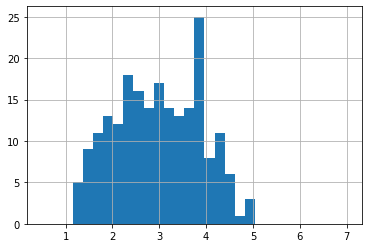

In [21]:
predictions["MOS"].hist(bins=30, range=[.5,7], label="predictions")

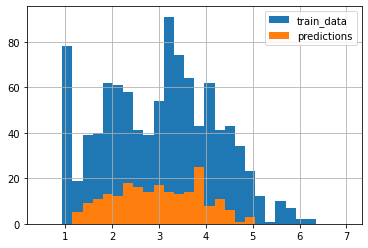

In [22]:
data["MOS"].hist(bins=30, range=[.5,7], label="train_data")
predictions["MOS"].hist(bins=30, range=[.5,7], label="predictions")
plt.legend()
plt.show()

In [23]:
nn.ReLU()(bert_model.pre_classifier_feats(get_feature_tensor(test_row).to(USE_DEVICE))) # 0 = nutzloses feature?

tensor([1.5676, 0.0000], device='cuda:0', grad_fn=<ReluBackward0>)